# Biomedical Text Document Classification Using Gradient Boosting, with Model Interpretability
The objectives for this work are as follows:  
- Exploration of gradient boosting models
- Exploration of model interpretability using SHAP values
- Comparision of TF-IDF and SHAP interpretability

## Dataset description:  
For Biomedical text document classification, abstract and full papers(whose length less than or equal to 6 pages) available and used. This dataset focused on long research paper whose page size more than 6 pages. Dataset includes cancer documents to be classified into 3 categories like 'Thyroid_Cancer','Colon_Cancer','Lung_Cancer'.  
Total publications=7569. it has 3 class labels in dataset.  
Number of samples in each categories:  
colon cancer=2579, lung cancer=2180, thyroid cancer=2810  

URL: https://www.kaggle.com/datasets/falgunipatel19/biomedical-text-publication-classification

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import shap
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [108]:
df = pd.read_csv('../data/alldata_1_for_kaggle.csv', encoding='latin-1', index_col=0).sample(frac=.25).reset_index(drop=True)
df.head()

,0,a
0,Colon_Cancer,primary colorectal cancer pcrc is a common dig...
1,Colon_Cancer,""" micrornas mirnas have been reported to have ..."
2,Colon_Cancer,"""dysregulation of bcl2 is a pathophysiology ob..."
3,Thyroid_Cancer,prevalence of pathogenic variants in DnA dama...
4,Lung_Cancer,"""The time-varying exposure profiles for ns sub..."


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1892 non-null   object
 1   a       1892 non-null   object
dtypes: object(2)
memory usage: 29.7+ KB


In [110]:
df.columns = ['cancer_type', 'text']

In [111]:
df['cancer_type'].value_counts()

cancer_type
Thyroid_Cancer    714
Colon_Cancer      635
Lung_Cancer       543
Name: count, dtype: int64

In [112]:
df.text[0]

'primary colorectal cancer pcrc is a common digestive tract cancer in the elderly the primary lesioncan be seen in the left colon the right colon the upper or lower rectum   pcrc is the second mostcommonly diagnosed cancer in women and the third most commonly diagnosed cancer in men and theprevalence of male is higher than that of female in most areas   with the social environment lifestyleand dietary structure changes the incidence of pcrc is on the rise and there is a trend of rejuvenationthis is a social issue worthy of attention   at present there is controversy about the pathogenesis ofpcrc it is generally believed that smoking drinking greasy diet obesity lack of exercise colorectalinflammation and genetic factors are all involved in the onset of cancer but these factors are also the causeof many other tumors therefore the specific etiological mechanism of pcrc has not yet been elucidated  some scholars believe that some genes or molecules are involved in the development of pcrc 

In [113]:
def clean_text(text):
    text = text.lower()
    text = ' '.join(text.split())
    text = re.sub (r'([^a-zA-Z ]+?)', '', text)
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    text = ' '.join([word for word in words if word not in stop_words])
    return text

# print(clean_text(df.text[0]))
# clean_text(' b  !!  hello')


In [114]:
df['clean_text'] = df.text.apply(clean_text)

In [115]:
df.head(2)

,cancer_type,text,clean_text
0,Colon_Cancer,primary colorectal cancer pcrc is a common dig...,primary colorectal cancer pcrc common digestiv...
1,Colon_Cancer,""" micrornas mirnas have been reported to have ...",micrornas mirnas report important regulatory r...


In [116]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.cancer_type, test_size=0.2, random_state=42)

In [117]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    max_df=.5,
    min_df=5,
    stop_words='english'
    )

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [118]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [119]:
clf = GradientBoostingClassifier(random_state=42).fit(X_train_tfidf, y_train)

accuracy: 0.9815303430079155
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       130
           1       1.00      0.99      1.00       106
           2       0.97      0.99      0.98       143

    accuracy                           0.98       379
   macro avg       0.98      0.98      0.98       379
weighted avg       0.98      0.98      0.98       379



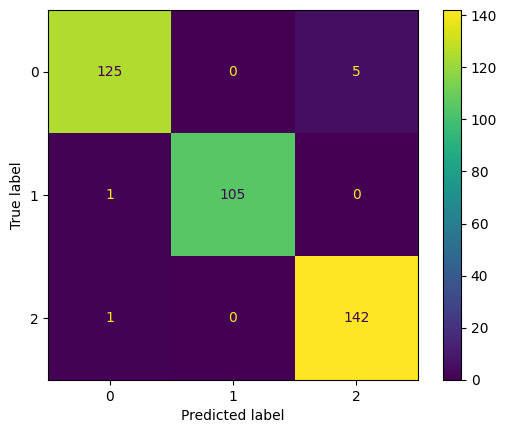

In [120]:
y_pred = clf.predict(X_test_tfidf)
print('accuracy:', accuracy_score(y_test, y_pred))
# print('recall:', recall_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test, y_pred))

## Most important features, per TF-IDF

In [121]:
def get_top_n_terms(tfidf_matrix, vectorizer, n):
    '''Get the top N most important terms, per tf-idf'''
    feature_names = vectorizer.get_feature_names_out()
    tfidf_sum = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
    sorted_indices = np.argsort(tfidf_sum)[::-1]
    top_n_terms = [feature_names[i] for i in sorted_indices[:n]]
    top_n_scores = [tfidf_sum[i] for i in sorted_indices[:n]]

    return list(zip(top_n_terms, top_n_scores))

n = 20

top_n_terms_and_scores = get_top_n_terms(X_train_tfidf, vectorizer, n)

scores_df = pd.DataFrame()
for term, score in top_n_terms_and_scores:
    scores_df = pd.concat([scores_df, pd.DataFrame({'term': [term], 'TF-IDF Score': [score]})])
scores_df


,term,TF-IDF Score
0,genes,30.950216
0,et,26.193128
0,risk,24.011562
0,covid,23.919360
0,breast,21.366413
0,mice,20.989913
0,nsclc,20.958447
0,figure,19.664094
0,al,19.306927
0,age,18.454033


## Most important features, per the Scikit-Learn model

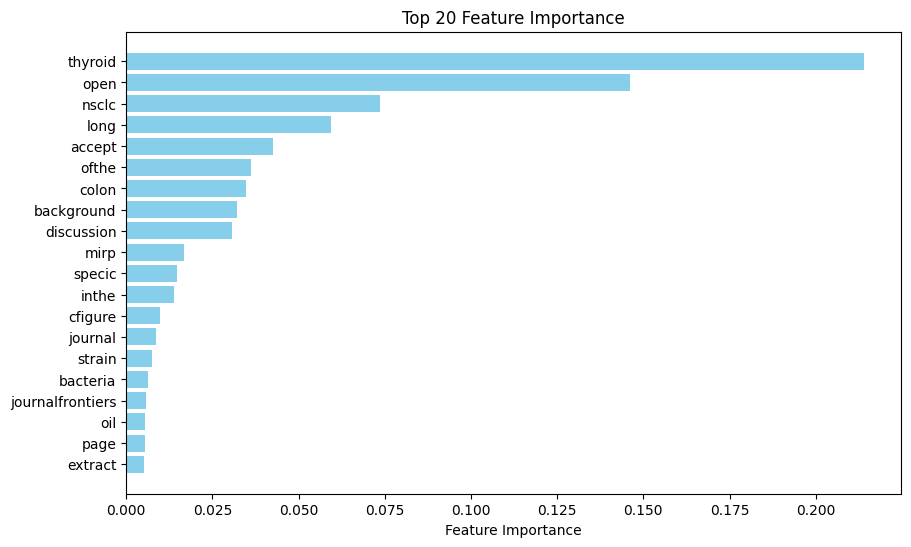

In [122]:
feature_importances = clf.feature_importances_

# Sort the feature importances and select the top N features
N = 20  # Number of top features to display
top_N_indices = np.argsort(feature_importances)[::-1][:N]
top_N_feature_importances = feature_importances[top_N_indices]
column_names = vectorizer.get_feature_names_out()
top_N_feature_names = [column_names[i] for i in top_N_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_N_feature_names, top_N_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title(f'Top {N} Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [123]:
top_N_feature_names

['thyroid',
 'open',
 'nsclc',
 'long',
 'accept',
 'ofthe',
 'colon',
 'background',
 'discussion',
 'mirp',
 'specic',
 'inthe',
 'cfigure',
 'journal',
 'strain',
 'bacteria',
 'journalfrontiers',
 'oil',
 'page',
 'extract']

## Most important features, per the SHAP values
Note: One of the downsides of the SHAP method is that it is computationaly intensive. The SHAP library was unable to provide an output in a reasonable amount of time on the vectorized data above. As a workaround to have some comparison of SHAP, the top terms from the gradient boosting algorithm used to create a filtered vocabulary, which was used to create a smaller model for use by SHAP.

In [125]:
def get_top_N_gbm_terms(model, vectorizer, N):
    feature_importances = model.feature_importances_
    top_N_indices = np.argsort(feature_importances)[::-1][:N]
    top_N_feature_importances = feature_importances[top_N_indices]
    column_names = vectorizer.get_feature_names_out()
    top_N_feature_names = [column_names[i] for i in top_N_indices]
    return top_N_feature_names

num_gbm_terms_to_keep = 200
gbm_terms = get_top_N_gbm_terms(clf, vectorizer, num_gbm_terms_to_keep)

In [126]:
gbm_terms
def filter_for_gbm_terms(text, gbm_terms):
    text = [word for word in text.split() if word in gbm_terms]
    return ' '.join(text)

df['filtered'] = df.clean_text.apply(lambda x: filter_for_gbm_terms(x, gbm_terms))
df.head(2)

,cancer_type,text,clean_text,filtered
0,Colon_Cancer,primary colorectal cancer pcrc is a common dig...,primary colorectal cancer pcrc common digestiv...,colorectal colon colon women incidence smoke t...
1,Colon_Cancer,""" micrornas mirnas have been reported to have ...",micrornas mirnas report important regulatory r...,biological regulate women regulate mechanism c...


In [127]:
X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(df.filtered, df.cancer_type, test_size=0.2, random_state=42)
vectorizer_gbm = TfidfVectorizer(
    analyzer='word',
    max_df=.5,
    min_df=5,
    stop_words='english'
    )

X_train_tfidf_gbm = vectorizer_gbm.fit_transform(X_train_gbm)
X_test_tfidf_gbm = vectorizer_gbm.transform(X_test_gbm)

In [128]:
le_gbm = LabelEncoder()
y_train_gbm = le.fit_transform(y_train_gbm)
y_test_gbm = le.transform(y_test_gbm)

In [129]:
import xgboost
d_train = xgboost.DMatrix(X_train_tfidf_gbm, label=y_train_gbm)
d_test = xgboost.DMatrix(X_test_tfidf_gbm, label=y_test_gbm)
params = {
    "eta": 0.01,
    "objective": "multi:softmax",
    "subsample": 0.5,
    "base_score": np.mean(y_train_gbm),
    "eval_metric": "logloss"
}

xgb_clf = xgboost.XGBClassifier(objective='multi:softmax', 
                            num_class=len(np.unique(y_train_gbm)), 
                            seed=42)

xgb_clf.fit(X_train_tfidf_gbm, 
            y_train_gbm)#,

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

accuracy: 0.9630606860158312
              precision    recall  f1-score   support

           0       0.98      0.92      0.94       130
           1       0.96      1.00      0.98       106
           2       0.95      0.98      0.97       143

    accuracy                           0.96       379
   macro avg       0.96      0.96      0.96       379
weighted avg       0.96      0.96      0.96       379



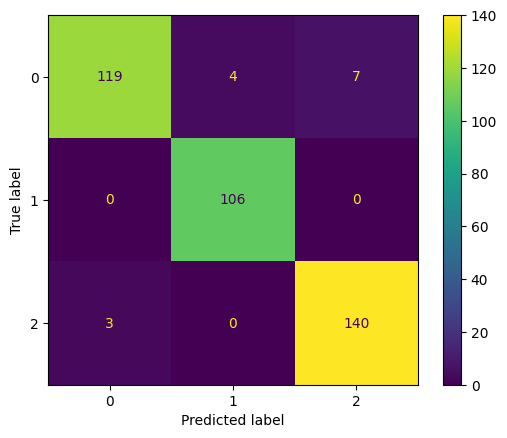

In [130]:
y_pred_gbm = xgb_clf.predict(X_test_tfidf_gbm)
print('accuracy:', accuracy_score(y_test_gbm, y_pred_gbm))
cm = confusion_matrix(y_test_gbm, y_pred_gbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

print(classification_report(y_test_gbm, y_pred_gbm))

In [132]:
explainer = shap.Explainer(xgb_clf)

# Compute SHAP values
instance_to_explain = X_test_tfidf_gbm[0].toarray()
class_to_explain = xgb_clf.predict(instance_to_explain)[0]  # explain the predicted class

shap_values = explainer.shap_values(instance_to_explain, check_additivity=False)[class_to_explain]

shap.initjs()
shap.force_plot(explainer.expected_value[class_to_explain], shap_values, instance_to_explain, feature_names=vectorizer_gbm.get_feature_names_out())


[22:15:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


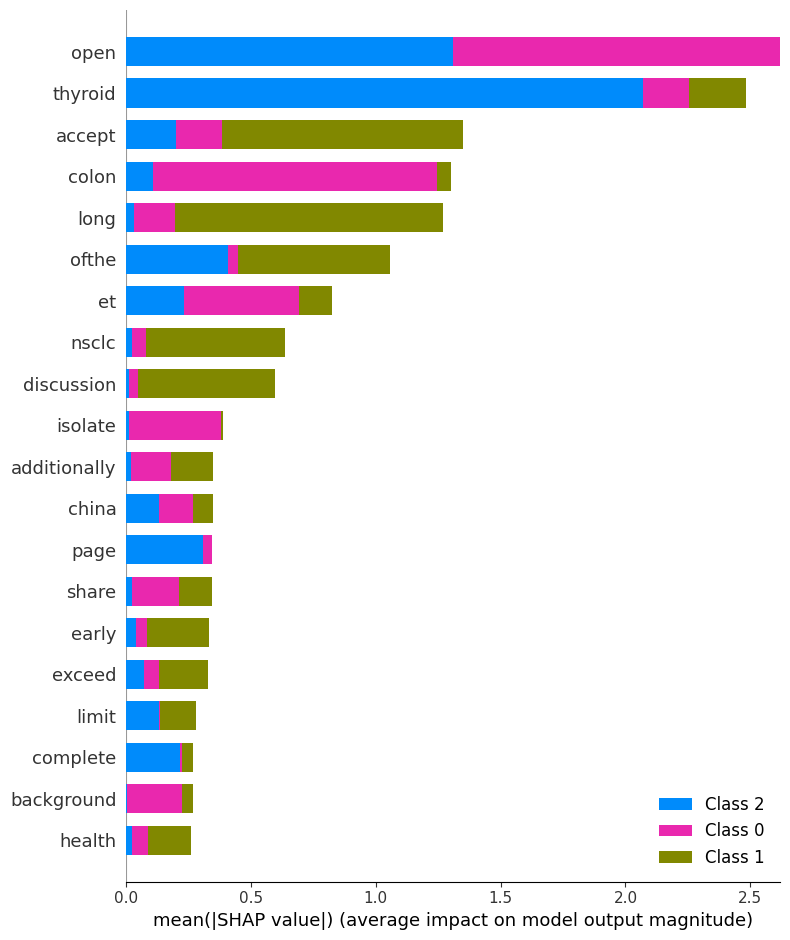

In [134]:
shap_values = explainer.shap_values(X_test_tfidf_gbm)
shap.summary_plot(shap_values, X_test_tfidf_gbm, feature_names=vectorizer_gbm.get_feature_names_out())


# Conclusion
In evaluating the most important terms as determined by the TF-IDF, gradient boosting, and XGBoost algorithms, there is overlap (or near overlap in meaning) with terms such as *nsclc* and *mice/animal*. The TF-IDF model appeared to focus more on shorter terms and acronyms, which may indicate stronger susceptibility to noise. The gradient boosting model focused more on whole words while also picking up on *NSCLC* (Non-Small Cell Lung Cancer Treatment), however missed *EGFR* (epidermal growth factor receptor). The gradient boosting model appears to have better interpretability in this case. Since the SHAP values were produced from the filtered results of the gradient boosting model, the high degree of overlap is unsurprising. The SHAP summary plot provides a high degree of information regarding the contribution of features to the various target classes.